In [ ]:
  from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! git clone https://github.com/Amal-AK/FLAKYCAT

Cloning into 'FLAKYCAT'...
remote: Enumerating objects: 1378, done.
remote: Counting objects: 100% (1378/1378), done.
remote: Compressing objects: 100% (706/706), done.
remote: Total 1378 (delta 679), reused 1364 (delta 670), pack-reused 0
Receiving objects: 100% (1378/1378), 21.26 MiB | 10.87 MiB/s, done.
Resolving deltas: 100% (679/679), done.


##Install Trax and transformers
Trax is not compatible with Windows

In [ ]:
!pip install transformers
!pip install trax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.9/637.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 100.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 40.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found e

##Import libraries

In [ ]:
import trax
from trax import layers as tl
import trax.fastmath.numpy as fastnp
from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel

#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base")
np.random.seed(123456)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


###Data infos

In [ ]:
# Replace the path with your own.
filenames_v0 = next(walk("./data/test_files_v0" ), (None, None, []))[2]
filenames_v12 = next(walk("./data/test_files_v12" ), (None, None, []))[2]

categories =  {}
for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower()
    if label not in categories.keys() :
      categories[label] = 0
    categories[label] += 1

for file in filenames_v12:
    label = (file.split("@")[1]).split('.')[0].strip().lower()
    if label not in categories.keys() :
      categories[label] = 0
    categories[label] += 1

print("\n==> All data : \n")
for x , y in categories.items() :
  print(x , y)


==> All data : 

async wait 376
test order dependency 291
network 93
time 122
concurrency 144
test case timeout 42
too restrictive range 9
unordered collections 153
randomness 50
resource leak 28
i_o 6
floating point operations 9
platform dependency 6


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##Transform source code to vectors

In [ ]:
def code_to_vector (  tests_path ) :
  '''
  inputs
  tests_path : location of code files

  outputs
  short_tests : Dictionary of test vectors with less than 512 tokens
  long_tests : Dictionary of test vectors with  more than 512 tokens

  '''
  short_tests = { }
  long_tests  =  {}
  filenames = next(walk(tests_path ), (None, None, []))[2]
  for file in filenames :
      parts =  []
      f = open(os.path.join(tests_path, file), 'r', encoding="utf8")
      label = (file.split("@")[1]).split('.')[0].strip().lower()
      lines = f.readlines()
      code = ""
      name = file.split("@")[0]
      for line in lines :
        if not "@Test"  in line :
          code = code + " " + " ".join( line.strip().split())
      code_tokens=tokenizer.tokenize( code , return_tensors="pt")
      tokens = [tokenizer.cls_token] + code_tokens  + [tokenizer.sep_token]

      # codeBERT input is limited to 512 tokens including special tokens
      if(len(tokens) < 512) :
          tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
          cls = model_codebert(torch.tensor(tokens_ids)[None,:])[1]
          vector = cls[0].detach().numpy()
          if ( not label in short_tests.keys() ) :
              short_tests[label] = dict()
          short_tests[label][name] = vector

      else :
          i = 0
          while ( i < len(code_tokens)-200) :
            tokens = [tokenizer.cls_token] + code_tokens[i:i+250] +[tokenizer.sep_token]
            tokens_ids= tokenizer.convert_tokens_to_ids(tokens)
            cls = model_codebert(torch.tensor(tokens_ids)[None,:])[1]
            vector = cls[0].detach().numpy()
            parts.append( vector)
            i = i+100
          if ( not label in long_tests.keys() ) :
              long_tests[label] = dict()
          long_tests[label][name] = parts
      f.close()
  return short_tests , long_tests


In [ ]:
# Replace the path with the placement of the data files in your project.
short_data , large_data = {} , {}
short_data , large_data  = code_to_vector('./data/test_files_v0/')

# Generated data
generated_short_data , generated_large_data = {} , {}
generated_short_data , generated_large_data = code_to_vector('./data/test_files_v12/')

###Import saved data vectors

In [ ]:
#Replace the path with your own
VectorsFolder = "./data/vectors/"
with open(VectorsFolder + "short_original_data.txt", 'r') as f:
    short_data = json.loads (json.load(f) )
with open(VectorsFolder + "large_original_data.txt", 'r') as f:
    large_data  = json.loads (json.load(f) )
with open(VectorsFolder + "short_generated_data.txt", 'r') as f:
    generated_short_data  = json.loads ( json.load(f) )
with open(VectorsFolder + "large_generated_data.txt", 'r') as f:
    generated_large_data  = json.loads (json.load(f))

###Save data vectors

In [ ]:
#make ndarrays serializables
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


# Replace the path with the placement of the data files

VectorsFolder = "./data/vectors/"


with open(VectorsFolder + "short_original_data.txt", 'w') as f:
    json.dump( json.dumps(short_data , cls=NumpyEncoder), f)
with open(VectorsFolder + "large_original_data.txt", 'w') as f:
    json.dump(json.dumps(large_data, cls=NumpyEncoder) , f)
with open(VectorsFolder + "short_generated_data.txt", 'w') as f:
    json.dump(json.dumps(generated_short_data, cls=NumpyEncoder), f)
with open(VectorsFolder + "large_generated_data.txt", 'w') as f:
    json.dump(json.dumps(generated_large_data , cls=NumpyEncoder), f)


## Secondary functions

In [ ]:
# merge a list of dictionaries
def merge_dicts(dict_args):
  '''
  inputs
  dict_args : list of dictionaries to merge

  outputs
  result : merged dictionary

  '''
  result = {}
  for dictionary in dict_args:
    for k , v in dictionary.items() :
      if ( k not in result.keys()):
        result[k] = {}
      for x , y in v.items() :
        result[k][x] = y
  return result


# calculate the cosine similarity
def cos_similarity (x , y ) :
  '''
  x , y : two vectors with the same dimension
  return the cosine similarity between x and y

  '''
  x = normalize(fastnp.array(x))
  y = normalize(fastnp.array(y))
  if(x.ndim > 1 ):
    return fastnp.diagonal(fastnp.dot(x, y.T) )
  else :
    return fastnp.dot(x, y.T)



# nomalize a matrix
def normalize(x):
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))

# the most frequent element in a list
def most_frequent(List):
    return max(set(List), key = List.count)


# calculate AUC for multi-class problems
def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)


# divide the data into training and test data

def divide_data ( X , rate ) :
  np.random.seed(123456)
  train_data , test_data =  dict() , dict()
  for key , value in X.items() :
     l = list(value.items())
     np.random.shuffle(l)
     value = dict(l)
     number = int(round(rate*len(value.keys())))
     test_data[key] , train_data[key] = dict(list(value.items())[:number])  ,  dict(list(value.items())[number:])

  return train_data , test_data



def shuffle_dict(dic) :
  ls = list(dic.items())
  np.random.shuffle(ls)
  dic = dict(ls)
  return dic

##Filter and split data

In [ ]:
#Consider data with more than 30 examples.
#data use the following  format :  {"flakiness category" : {"testName1" : codeBERT vector , ........} , .......}

data = dict()
for x , y in short_data.items() :
   if len(y) >= 30 :
     data[x] = y

generated_data= dict()
for x , y in generated_short_data.items() :
   if (x in data.keys()) :
     generated_data[x] = y

long_data = dict()
for x , y in large_data.items() :
   if (x in data.keys()) :
     long_data[x] = y


X_train , X_test = divide_data(data , 0.25)



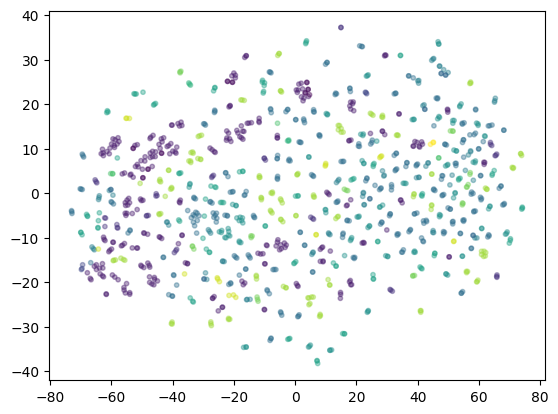

In [ ]:

%matplotlib inline

X= []
labels = []
d = merge_dicts([short_data, generated_short_data])
for k , v in d.items() :
  X = X + list(v.values())
  labels = labels + ( [k] * len(v) )

labelsdic = {list ( set (labels)) [i]: i for i in range(len(list ( set (labels)) ))}
labelsNums = [ labelsdic [l] for l in labels  ]
X_embedded= TSNE(n_components=2, init='random').fit_transform(torch.tensor(X))
plt.scatter(torch.tensor(X_embedded[:, 0]), torch.tensor(X_embedded[:, 1] ), c=labelsNums[:len(X_embedded)], s=10, cmap='viridis' , alpha=0.4 );


### Stratified k-folds

In [ ]:
def K_folds(data_to_divide , folds_number =10) :
  '''
  inputs
  data_to_divide : dictionary to split into k folds
  folds_number : number of folds to return

  outputs
  folds_tab : list of dictionaries

  '''
  folds_tab =   [{} for i in range(folds_number)]
  for k , v in data_to_divide.items() :
    l = list(v.items())
    np.random.shuffle(l)
    v = dict(l)
    tab_names = np.array_split( list(v.keys()) , folds_number)
    tab_vectors=  np.array_split( list( v.values() ) , folds_number)
    for i in range(folds_number) :
      if ( k not in folds_tab[i].keys()):
        folds_tab[i][k] = dict()
      for j in range(len(tab_names[i])) :
        folds_tab[i][k][tab_names[i][j]] = tab_vectors[i][j]
  return  folds_tab


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Define the Data generator
trax uses only genearators to train its models

In [ ]:
from itertools import combinations
from random import sample, shuffle

def data_generator(X, batch_size):
    '''
    Inputs:
    X : Data dictionary where each key is a label and each value is another dictionary mapping filenames to feature lists.
    batch_size : Number of examples in each batch.

    Outputs:
    batch1, batch2: Two batches of data arrays ready to be used by the Siamese model.
    labels: List of labels corresponding to the pairs in batch1 and batch2.
    '''
    batch1 = []
    batch2 = []
    labels = []
    keys = list(X.keys())
    while True:
        shuffle(keys)  # Shuffle to avoid seeing the same sequence each epoch
        for x in keys:
            y = X[x]
            #print(len(y),x)
            # Check if there are at least two items to form a pair
            if len(y) < 2:
                continue
            # Generate all possible pairs and sample one
            all_combinations = list(combinations(range(len(y)), 2))
            if not all_combinations:
                continue
            comb = sample(all_combinations, 1)[0]

            # Convert selected items to numpy arrays and reshape them
            values_list = list(y.values())
            batch1.append(np.array(values_list[comb[0]]).reshape(768))
            batch2.append(np.array(values_list[comb[1]]).reshape(768))
            labels.append(x)

            # Yield a batch if the desired batch size is reached
            if len(batch1) >= batch_size:
                yield np.array(batch1), np.array(batch2), np.array(labels)
                batch1, batch2, labels = [], [], []

##Siamese Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Siamese(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()
        # Define a dense layer as a linear layer followed by an activation
        self.dense = nn.Sequential(
            nn.Linear(768, 512),  # Linear transformation
            nn.ReLU()             # ReLU activation for non-linearity
        )

    def forward(self, b1, b2):
        # Process both inputs through the same dense layer
        processed_b1 = self.dense(b1)
        processed_b2 = self.dense(b2)
        return processed_b1, processed_b2

    def normalize(self, x):
        # Normalize the vectors to unit length
        return x / torch.norm(x, p=2, dim=1, keepdim=True)

##Triplet Loss function

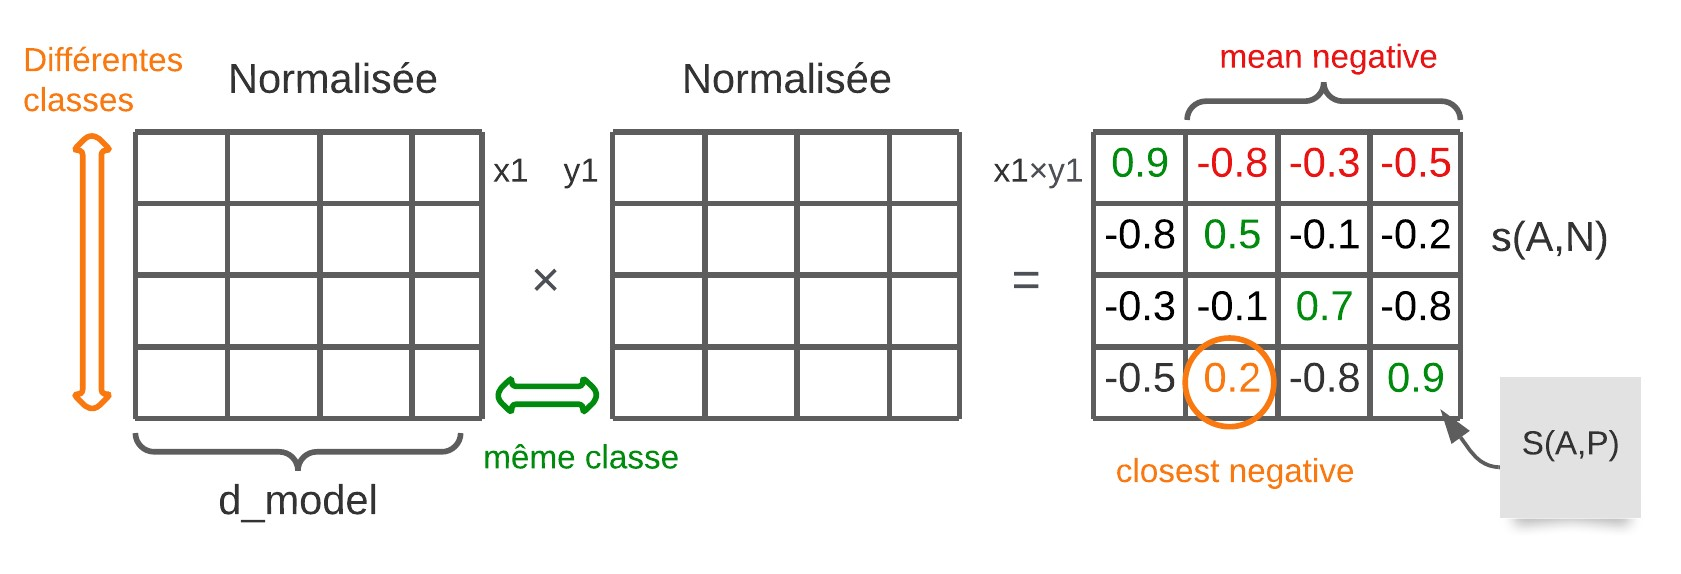

In [ ]:
lbl_to_idx={
    "time":0,
    "async wait":1,
    "test order dependency":2,
    "concurrency":3,
    "unordered collections":4
}
idx_to_lbl={
   0: "time",
   1: "async wait",
   2: "test order dependency",
   3: "concurrency",
   4: "unordered collections"
}
def sample_positive_negative(train_data, labels):
  negv1=[0,0,0,0,0]
  negv2=[0,0,0,0,0]
  posv1=[0,0,0,0,0]
  posv2=[0,0,0,0,0]
  #print(labels)
  for idx in range(len(labels)):

    curr_lbl = lbl_to_idx[labels[idx]]
    neg_lbl_1 = curr_lbl
    while neg_lbl_1 == curr_lbl:
      neg_lbl_1 = np.random.randint(0,5)
    neg_lbl_2 = curr_lbl
    while neg_lbl_2 == curr_lbl:
      neg_lbl_2 = np.random.randint(0,5)
    rand_neg_idx_1 = np.random.randint(0,len(train_data[idx_to_lbl[neg_lbl_1]]))
    rand_neg_idx_2 = np.random.randint(0,len(train_data[idx_to_lbl[neg_lbl_2]]))
    rand_pos_idx_1 = np.random.randint(0,len(train_data[idx_to_lbl[curr_lbl]]))
    rand_pos_idx_2 = np.random.randint(0,len(train_data[idx_to_lbl[curr_lbl]]))
    #print(rand_neg_idx_1, rand_neg_idx_2, rand_pos_idx_1, rand_pos_idx_2)
    #print("arr lens",len(train_data[idx_to_lbl[neg_lbl_1]]), len(train_data[idx_to_lbl[neg_lbl_2]]), len(train_data[idx_to_lbl[curr_lbl]]),  )
    #print(negv1[idx])
    negv1[idx] = torch.tensor(train_data[idx_to_lbl[neg_lbl_1]][rand_neg_idx_1])
    negv2[idx] = torch.tensor(train_data[idx_to_lbl[neg_lbl_2]][rand_neg_idx_2])
    posv1[idx] = torch.tensor(train_data[idx_to_lbl[curr_lbl]][rand_pos_idx_1])
    posv2[idx] = torch.tensor(train_data[idx_to_lbl[curr_lbl]][rand_pos_idx_2])

  return torch.stack(negv1),torch.stack(negv2),torch.stack(posv1),torch.stack(posv2)

def triplet_loss(v1, v2, labels, train_data, margin=1.0):
    # Convert train_data to the format needed for sampling
    converted_dict = {label: list(file_dict.values()) for label, file_dict in train_data.items()}

    # Sample negative and positive data items for v1 and v2
    neg_v1, neg_v2, pos_v1, pos_v2 = sample_positive_negative(converted_dict, labels)

    neg_v1 = F.adaptive_avg_pool1d(neg_v1.unsqueeze(0), 512).squeeze(0)
    neg_v2 = F.adaptive_avg_pool1d(neg_v2.unsqueeze(0), 512).squeeze(0)
    pos_v1 = F.adaptive_avg_pool1d(pos_v1.unsqueeze(0), 512).squeeze(0)
    pos_v2 = F.adaptive_avg_pool1d(pos_v2.unsqueeze(0), 512).squeeze(0)

    # Compute the Euclidean distance between pos_v1 and v1
    distance_positive_v1 = (pos_v1 - v1).pow(2).sum(dim=1)  # Sum over the feature dimension

    # Compute the Euclidean distance between pos_v2 and v2
    distance_positive_v2 = (pos_v2 - v2).pow(2).sum(dim=1)  # Sum over the feature dimension

    # Sum the positive distances for a combined positive measure
    distance_positive = distance_positive_v1 + distance_positive_v2

    # Compute the Euclidean distance between neg_v1 and v1
    distance_negative_v1 = (neg_v1 - v1).pow(2).sum(dim=1)  # Sum over the feature dimension

    # Compute the Euclidean distance between neg_v2 and v2
    distance_negative_v2 = (neg_v2 - v2).pow(2).sum(dim=1)  # Sum over the feature dimension

    # Sum the negative distances for a combined negative measure
    distance_negative = distance_negative_v1 + distance_negative_v2

    # Compute the triplet loss with the margin
    losses = torch.relu(distance_positive - distance_negative + margin)

    # Return the mean of these losses
    return losses.mean()


# def triplet_loss(v1, v2, labels, train_data, margin=0.3):
#     converted_dict = {label: list(file_dict.values()) for label, file_dict in train_data.items()}
#     #print(converted_dict['concurrency'][0])
#     negv1,negv2,posv1,posv2 = sample_positive_negative(converted_dict, labels)
#     #print(negv1)
#     v1 = v1 / torch.norm(v1, p=2, dim=1, keepdim=True)
#     v2 = v2 / torch.norm(v2, p=2, dim=1, keepdim=True)
#     scores = torch.mm(v1, v2.T)
#     batch_size = scores.size(0)
#     positive_scores = torch.diagonal(scores)
#     negative_without_positive = scores - 2.0 * torch.eye(batch_size, device=scores.device)
#     closest_negative = negative_without_positive.max(1)[0]
#     negative_zero_on_duplicate = scores * (1.0 - torch.eye(batch_size, device=scores.device))
#     mean_negative = negative_zero_on_duplicate.sum(1) / (batch_size - 1)
#     triplet_loss1 = torch.clamp(margin - positive_scores + closest_negative, min=0.0)
#     triplet_loss2 = torch.clamp(margin - positive_scores + mean_negative, min=0.0)
#     loss = (triplet_loss1 + triplet_loss2).mean()
#     return loss

#Train function

In [ ]:
import gzip
import pickle
def train_model(train_generator, num_epochs, train_data, max_steps_per_epoch, lr=0.001, margin=0.3):
    model = Siamese()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(num_epochs):
        print(epoch)
        total_loss = 0
        for i, (b1, b2, labels) in enumerate(train_generator):
            if i >= max_steps_per_epoch:
              break
            b1 = torch.tensor(b1, dtype=torch.float32)
            b2 = torch.tensor(b2, dtype=torch.float32)
            optimizer.zero_grad()
            v1, v2 = model(b1, b2)
            loss = triplet_loss(v1, v2, labels, train_data, margin)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {total_loss / (i + 1)}")

        # Ensure the directory for saving the model exists
        model_save_path = '/content/drive/MyDrive/model.pkl.gz'
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

        # Save the model
        with gzip.open(model_save_path, 'wb') as f:
            pickle.dump(model.state_dict(), f)

        print(f"Model saved to {model_save_path} after epoch {epoch + 1}")


##Select support set

In [ ]:
def get_support_set(data , model , number):
  '''
  inputs
  data : data to select
  model :  siamese model to transform the data
  number : number of examples for each flakiness category

  outputs
  support_set : selected support_set , the most central data

  '''
  model_vectors = dict()
  support_set = dict()
  for key , value in data.items():
    model_vectors[key] = {}
    for test in value.keys() :
      try :
        v = model( torch.tensor(np.array(data[key][test])) , torch.tensor(np.array(data[key][test] )) )[0]
        model_vectors[key][test] = v
      except :
        print(data[key][test])

  means_names = {}
  for key , value in model_vectors.items():
    mean_point = np.mean( list(model_vectors[key].values()) , axis=0)
    distances = []
    for cle in value.keys() :
      distances.append( [ distance.euclidean( mean_point , model_vectors[key][cle]) ,  cle] )
    distances.sort(key=lambda tab: tab[0])
    means_names[key] = [ elem[1]  for elem in distances[:number]]
    support_set[key] = dict()
    for Name in means_names[key] :
      support_set[key][Name] = data[key][Name]


  return support_set


In [ ]:
import numpy as np
import torch
from scipy.spatial import distance

def get_support_set(data, model, number):
    '''
    Inputs:
    data : Dictionary with keys as categories and values as dictionaries of data points
    model : Siamese model to transform the data
    number : Number of examples for each category to be selected as the support set

    Outputs:
    support_set : Dictionary with selected central data points for each category
    '''
    model_vectors = dict()
    support_set = dict()

    for key, value in data.items():
        model_vectors[key] = {}
        for test_key in value.keys():
            input_data = np.array(data[key][test_key], dtype=np.float32)
            try:
                # Ensure input data is correctly shaped and wrapped as a tensor
                input_tensor = torch.tensor(input_data).unsqueeze(0)  # Example shaping, adjust as necessary
                v = model(input_tensor, input_tensor)[0]
                model_vectors[key][test_key] = v.detach().numpy()  # Detach if using PyTorch
            except Exception as e:
                # Log the error with the key information for easier debugging
                print(f"Error processing data for key {key}, test_key {test_key}: {str(e)}")
                continue  # Optionally continue to the next iteration

    for key, vectors in model_vectors.items():
            if vectors:
                mean_point = np.mean(list(vectors.values()), axis=0).ravel()  # Ensure mean_point is 1-D
                distances = []
                for test_key, vec in vectors.items():
                    vec = vec.ravel()  # Ensure vec is 1-D
                    dist = distance.euclidean(mean_point, vec)
                    distances.append((dist, test_key))
                distances.sort()
                means_names = [test_key for _, test_key in distances[:number]]
                support_set[key] = {name: data[key][name] for name in means_names}

    return support_set


##FSL Classifier

In [ ]:
def normalize_fn(x):
    # Ensure x is a torch tensor
    x = torch.as_tensor(x, dtype=torch.float32)  # Convert input to torch tensor if it's not

    # Compute the norm over the last dimension, keep the dimension for broadcasting
    norm = torch.sqrt(torch.sum(x * x, axis=-1, keepdim=True))
    return x / norm
def smallTestsclassifier(   model,  query  ,  support_set  ):
  '''
  inputs
  model : Siamese model
  query : the examplt to classify
  support_set : examples for each category

  outputs
  SimilarityDic : the similarity scores calculated for each category
  label : predicted label

  '''

  matrix_similarities = []
  SimilarityDic= {}
  for key , value in support_set.items() :
      y = np.matrix(list(value.values()))
      x1 = [query] * y.shape[0]
      x1 = np.matrix(x1)
      #print(x1,y)
      x1 = torch.tensor(x1).float()
      y = torch.tensor(y).float()
      v1, v2 = model( x1 , y )
      v1 =  normalize_fn(v1).detach().numpy()
      v2 = normalize_fn(v2).detach().numpy()
      sim = np.dot(v1, v2.T)
      d =   np.mean( np.diag ( sim ))
      SimilarityDic[key] = d
  label = max(SimilarityDic, key=SimilarityDic.get)

  return  SimilarityDic , label


In [ ]:
def longTestsClassifier ( model,  query ,  support_set ) :
  '''
  inputs
  model : Siamese model
  query : the examplt to classify
  support_set : examples for each category

  outputs
  SimilarityDictionnary : the similarity scores calculated for each category
  most_frequent(labels_predicted) : predicted label

  '''

  labels_predicted =  []
  for TestPart in query :
    SimilarityDictionnary , label = smallTestsclassifier(model , TestPart  , support_set)
    SimilarityValues  = list ( SimilarityDictionnary.values() )
    SimilarityValues.sort(reverse=True)
    if SimilarityValues[0]  > 0.6 :
      labels_predicted.append(label)
  return  SimilarityDictionnary , most_frequent(labels_predicted)

In [ ]:
def classifier (model,  test_data  ,  support_set) :

  '''
  inputs
  model : Siamese model
  query : data to classify
  support_set : examples for each category

  outputs
  predictedLabels : predicted labels for test data
  Sim_matrix : similarity scores
  '''
  Sim_matrix =  []
  predictedLabels =  []
  for query in test_data :
    if len(query )== 768  :
      score , label  = smallTestsclassifier ( model , query , support_set)
    else :
      score, label  = longTestsClassifier ( model , query , support_set)
    predictedLabels.append(label)
    Sim_matrix.append(score)
  return predictedLabels , Sim_matrix

### 10-folds cross validation

In [ ]:
def cross_validation(train_steps , dir_name ,data_dic , data_augmented , learning_rate ,  n_warmup_steps , sim_margin , size_support_set) :
  '''
  Inputs
  train_steps : number of iterations
  dir_name : folder where to save the trained model
  data_dic : train data
  data_augmented :  generated data
  learning_rate : learning rate for the siamese model
  sim_margin : similarity margin used on the loss function
  size_support_set : number of examples representing each category in the support_set


  outputs
  f1_global : global f1 score using the 10-folds cross validation

  '''

  np.random.seed(123456)
  metrics_dict , support_set = {} , {}
  metrics_dict["f1_score"]  = []
  f1_score_per_class = []
  batch_size = len(list(data_dic.keys()))
  folds_array = K_folds(data_dic , 10)
  for i in range(len(folds_array )):
      eval_data = folds_array[i]
      train_data  = merge_dicts (folds_array[0:i] + folds_array[i+1:len(folds_array)])
      original_train_data = copy.deepcopy(train_data)

      # Add the data generated after the split to not include similar copies in the train and test
      for label , value in data_augmented.items() :
        for test_name  , vector in value.items() :
          if ( test_name[3:] in train_data[label].keys() ) :
            train_data[label][test_name] = data_augmented[label][test_name]
          if ( test_name[3:] in eval_data[label].keys() ) :
            eval_data[label][test_name] = data_augmented[label][test_name]
      train_generator = data_generator(train_data , batch_size)
      !rm -rf model
      #training_loop = train_model( TripletLoss, original_train_data, sim_margin , learning_rate,  n_warmup_steps , train_generator , "model/")
      #training_loop.run(train_steps)
      train_model(train_generator, 200, train_data, lr=learning_rate, margin=sim_margin)
      #-------------------------------------------------------------------------------
      model = Siamese()
      model.init_from_file('model/model.pkl.gz')
      test_data_array =  []
      labels = []
      for label , vec in eval_data.items():
        test_data_array = test_data_array + list(vec.values())
        labels = labels + [label] * len(list(vec.values()))
      unique_labels = list ( set(labels ) )
      support_set =  get_support_set(original_train_data , model , size_support_set)
      predicted  , m = classifier(model , test_data_array  , support_set)

      #print (classification_report(labels, predicted))
      metrics_dict["f1_score"].append( metrics.f1_score(labels,  predicted ,  average='weighted'))

  f1_global =  np.round(np.average(metrics_dict["f1_score"]) , 2)

  return  f1_global


In [ ]:
warnings.filterwarnings("ignore")
output_dir = os.path.expanduser('~/model/')
train_data = copy.deepcopy(X_train)
F1_result  = cross_validation(10000, output_dir , train_data , generated_data ,learning_rate = 0.001 ,  n_warmup_steps = 400, sim_margin=0.30 , size_support_set= 10)
print(F1_result)

### Parameters Tunning

In [ ]:

def Random_Search ( data , generated_data  ,  max_iter,  percent= 0.3  ) :

    max_score = 0
    best_solution= None
    output_dir =  os.path.expanduser('~/model/')
    scores = list()
    learning_rates = [ 0.001 , 0.01 , 0.1 ]
    n_warmup = [400 , 600 , 800 ]
    sim_margin =  [ 0.22 , 0.25 , 0.27 , 0.28 , 0.3 ]
    support_set_size  = [  2, 10 , 15 ]
    parameters = []
    for j in learning_rates :
       for i in n_warmup :
          for x in  sim_margin :
            for y in  support_set_size  :
              parameters.append( ( j, i , x , y) )
    n = int(len(parameters) * percent)
    reduced_grid = sample(parameters, n)
    print(reduced_grid)
    n_iter = 0
    for k in range( len( reduced_grid  ) ) :
      if   n_iter < max_iter :
        n_iter += 1
        curr_score =    cross_validation( 10000 , output_dir , data , generated_data ,reduced_grid[k][0] , reduced_grid[k][1]  , reduced_grid[k][2] ,  reduced_grid[k][3])
        scores.append([reduced_grid[k] , curr_score ])
        print("\n Result for combination " , reduced_grid[k] , " : " , curr_score )
        if max_score < curr_score :
          max_score = curr_score
      else :
        break
    return max_score , best_solution , scores


In [ ]:
warnings.filterwarnings("ignore")
rnd.seed(123456)
train_data = copy.deepcopy(X_train)
best_score , best_solution , scores_to_plot = Random_Search( train_data , generated_data  ,  15 ,  percent= 0.2  )

[(0.01, 600, 0.3, 15), (0.001, 400, 0.27, 10), (0.001, 800, 0.3, 15), (0.001, 400, 0.22, 2), (0.001, 600, 0.25, 10), (0.001, 400, 0.3, 10), (0.01, 600, 0.27, 15), (0.1, 800, 0.3, 10), (0.001, 400, 0.3, 15), (0.1, 600, 0.3, 15), (0.001, 600, 0.3, 15), (0.01, 800, 0.27, 2), (0.01, 600, 0.22, 15), (0.1, 600, 0.28, 10), (0.001, 600, 0.27, 15), (0.1, 600, 0.3, 2), (0.001, 400, 0.25, 2), (0.01, 600, 0.27, 10), (0.1, 600, 0.28, 15), (0.001, 600, 0.22, 10), (0.01, 400, 0.25, 2), (0.1, 600, 0.27, 2), (0.01, 800, 0.27, 10), (0.1, 400, 0.28, 10), (0.01, 400, 0.22, 15), (0.001, 400, 0.25, 15), (0.1, 800, 0.22, 2)]

 Result for combination  (0.01, 600, 0.3, 15)  :  0.65

 Result for combination  (0.001, 400, 0.27, 10)  :  0.67

 Result for combination  (0.001, 800, 0.3, 15)  :  0.65

 Result for combination  (0.001, 400, 0.22, 2)  :  0.67

 Result for combination  (0.001, 600, 0.25, 10)  :  0.67

 Result for combination  (0.001, 400, 0.3, 10)  :  0.67

 Result for combination  (0.01, 600, 0.27, 15)

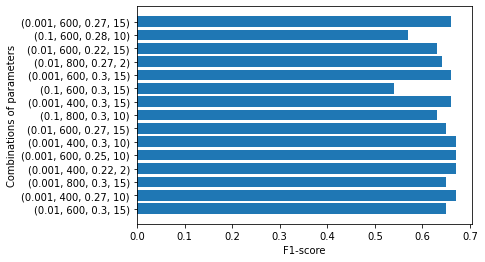

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
y , x = [] , []
for item in scores_to_plot :
  y.append(str(item[0]))
  x.append(item[1])

plt.barh(y, x)
plt.ylabel("Combinations of parameters")

plt.xlabel("F1-score")
plt.show()


#Final validation on holdout set

### Train model

In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore")
sim_margin = 0.3
learning_rate = 0.001
batch_size =  len(X_train.keys())
steps_per_epoch = (108+80+220+90+217) // batch_size
train_steps = 10000
size_support_set = 10
n_warmup_steps = 400
np.random.seed(123456)
test_data = copy.deepcopy(X_test)
train_data = copy.deepcopy (X_train)
for label , value in generated_data.items() :
  for test_name  , vector in value.items() :
    if ( test_name[3:] in train_data[label].keys() ) :
        train_data[label][test_name] = generated_data[label][test_name]
    if ( test_name[3:] in test_data[label].keys() ) :
        test_data[label][test_name] = generated_data[label][test_name]

print("\n\n ==> Train data : \n")
for x , y in train_data.items():
  print(x , len(y.keys()))
train_generator = data_generator(train_data, batch_size)
!rm -rf model
#print(len(list(train_generator)))
#training_loop = train_model(TripletLoss,  sim_margin , learning_rate, n_warmup_steps, train_generator , "model/")
print("\n\n=> Training in progress ...")
train_model(train_generator, 200, train_data, steps_per_epoch , lr=learning_rate, margin=sim_margin)
print("\n=> Training finished")




 ==> Train data : 

unordered collections 108
time 80
async wait 220
concurrency 90
test order dependency 217


=> Training in progress ...
0
Epoch 1/200, Average Loss: 0.6779546694338529
Model saved to /content/drive/MyDrive/model.pkl.gz after epoch 1
1
Epoch 2/200, Average Loss: 0.4506102266669687
Model saved to /content/drive/MyDrive/model.pkl.gz after epoch 2
2
Epoch 3/200, Average Loss: 0.45609488682950744
Model saved to /content/drive/MyDrive/model.pkl.gz after epoch 3
3
Epoch 4/200, Average Loss: 0.40382593581064913
Model saved to /content/drive/MyDrive/model.pkl.gz after epoch 4
4
Epoch 5/200, Average Loss: 0.39160622858778676
Model saved to /content/drive/MyDrive/model.pkl.gz after epoch 5
5
Epoch 6/200, Average Loss: 0.41023052278130007
Model saved to /content/drive/MyDrive/model.pkl.gz after epoch 6
6
Epoch 7/200, Average Loss: 0.3886174202327513
Model saved to /content/drive/MyDrive/model.pkl.gz after epoch 7
7
Epoch 8/200, Average Loss: 0.39397825241192347
Model saved to

### Test model

Model loaded successfully.
                       precision    recall  f1-score   support

           async wait       0.52      0.61      0.56        71
          concurrency       0.45      0.33      0.38        30
test order dependency       0.70      0.69      0.69        67
                 time       0.77      0.57      0.65        30
unordered collections       0.71      0.83      0.77        36

             accuracy                           0.62       234
            macro avg       0.63      0.61      0.61       234
         weighted avg       0.63      0.62      0.62       234


 - Accuracy :  0.62
 - Precision :  0.63
 - Recall :  0.62
 - F1 score :  0.62
 - MCC :  0.51
 - AUC :  0.75


Perfomnaces by categories



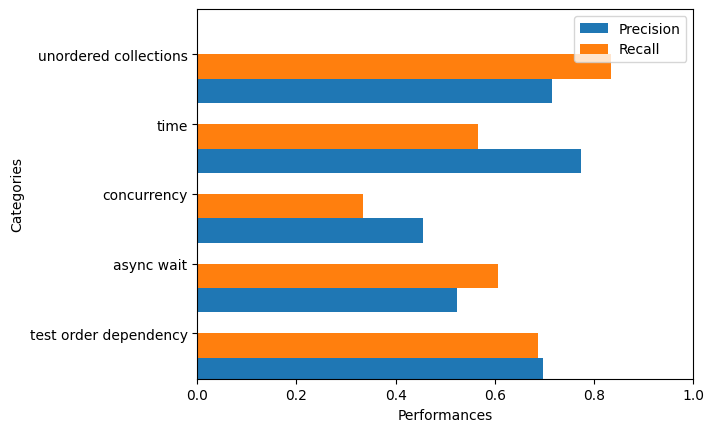



Confusion Matrix 


<Axes: >

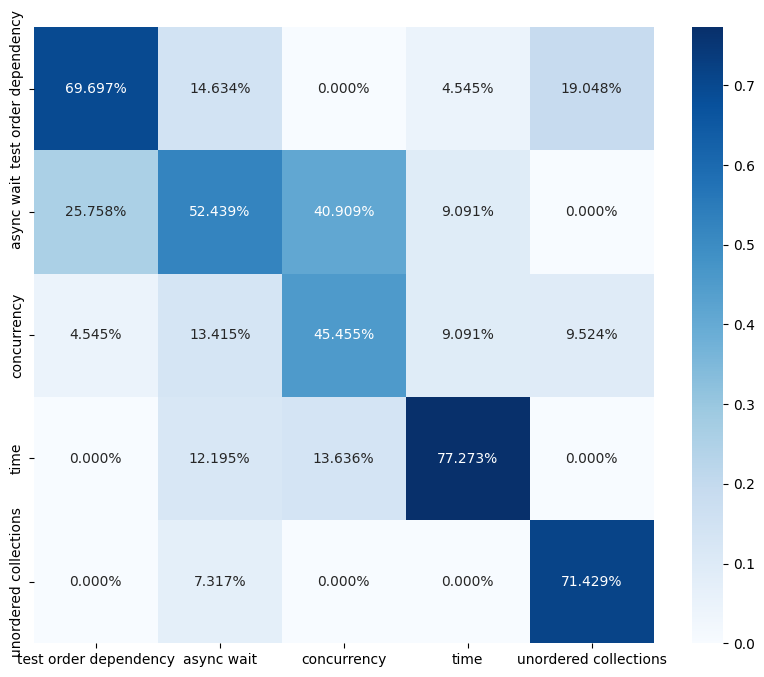

In [ ]:
model = Siamese()
# Define the path where the model is saved
model_save_path = '/content/drive/MyDrive/model.pkl.gz'

# Ensure the model file exists
if os.path.exists(model_save_path):
    # Load the model state dictionary from the gzip file
    with gzip.open(model_save_path, 'rb') as f:
        model_state_dict = pickle.load(f)

    # Load the state dictionary into the model
    model.load_state_dict(model_state_dict)
    print("Model loaded successfully.")
else:
    print(f"Model file not found at {model_save_path}.")
test_data_array =  []
labels = []
for label , vec in test_data.items():
  test_data_array = test_data_array + list(vec.values())
  labels = labels + [label] * len(list(vec.values()))
unique_labels = list ( set(labels ) )
support_set =  get_support_set(X_train , model , size_support_set)
predicted , sim_scores  = classifier(model , test_data_array  , support_set)
print (classification_report(labels, predicted))

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels,  predicted) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(labels,  predicted , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels,  predicted , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels,  predicted , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels,  predicted) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels,  predicted),2) )

print("\n\nPerfomnaces by categories\n")


ind = np.arange(len(unique_labels))
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='upper right')
ax.set_xlabel("Performances")
ax.set_ylabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(labels,  predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

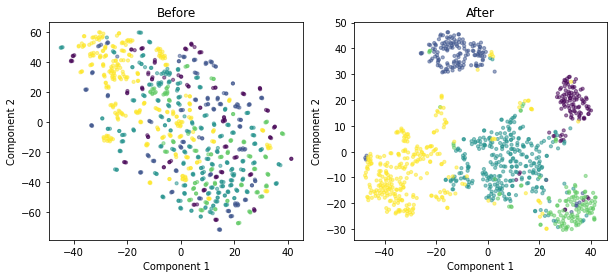

In [ ]:
%matplotlib inline
model = Siamese()
model.init_from_file('model/model.pkl.gz')
X= []
labels = []
X_1 = []
d = merge_dicts([data, generated_data])
for k , v in d.items() :
  X = X + list(v.values())
  labels = labels + ( [k] * len(v) )
labelsdic = {list ( set (labels)) [i]: i for i in range(len(list ( set (labels)) ))}
labelsNums = [ labelsdic [l] for l in labels  ]
i=0
while i < len(X)-1:
  x = np.array(X[i])
  y = np.array(X[i+1])
  i  +=  2
  v1  , v2 = model((x , y ))
  X_1.append(v1)
  X_1.append(v2)
X_1 = np.array(X_1)
X_embedded_2= TSNE(n_components=2, init='random').fit_transform(X_1)
X_embedded_1= TSNE(n_components=2, init='random').fit_transform(X)
fig , (ax1 , ax2) = plt.subplots(1,2, figsize=(10, 4))
ax1.scatter(X_embedded_1[:, 0], X_embedded_1[:, 1] , c=labelsNums[:len(X_embedded_1)], s=10 ,  cmap='viridis' , alpha=0.5)
ax2.scatter(X_embedded_2[:, 0], X_embedded_2[:, 1] , c=labelsNums[:len(X_embedded_2)], s=10 ,  cmap='viridis' , alpha=0.5)
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_title("Before")
ax2.set_title("After")
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
plt.show()


### Adding more classes




 ==> Train data : 

unordered collections 108
time 80
async wait 220
concurrency 90
network 19
test order dependency 213


=> Training in progress ...

=> Training finished
                       precision    recall  f1-score   support

           async wait       0.80      0.66      0.72        71
          concurrency       0.33      0.40      0.36        30
              network       0.27      0.67      0.38         6
test order dependency       0.70      0.76      0.73        71
                 time       1.00      0.60      0.75        30
unordered collections       0.69      0.75      0.72        36

             accuracy                           0.66       244
            macro avg       0.63      0.64      0.61       244
         weighted avg       0.71      0.66      0.68       244


 - Accuracy :  0.66
 - Precision :  0.71
 - Recall :  0.66
 - F1 score :  0.68
 - MCC :  0.57
 - AUC :  0.79


Perfomnaces by categories



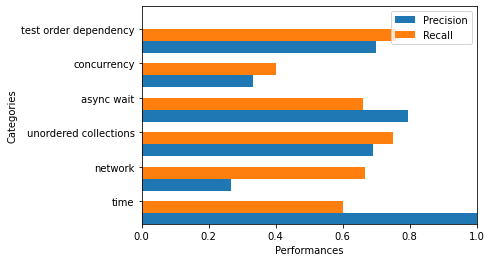



Confusion Matrix 


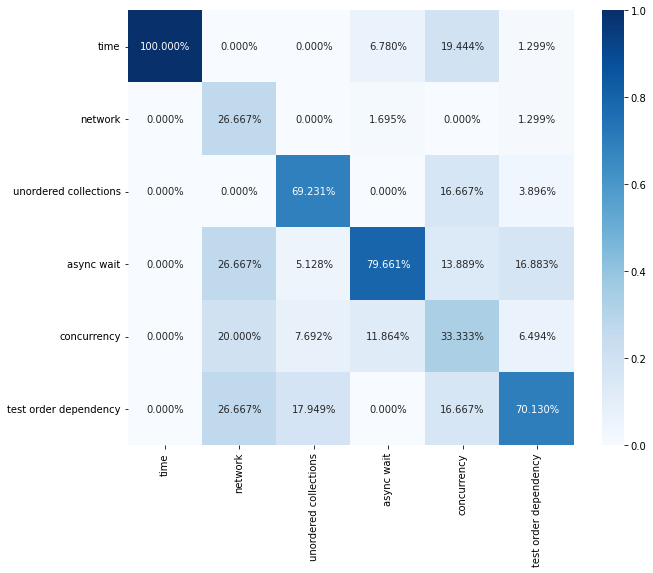

In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore")


data_1 = dict()
for x , y in short_data.items() :
   if len(y) >= 15 :
     data_1[x] = y

train_data_1 ,test_data_1 = divide_data(data_1 , 0.25)


sim_margin = 0.30
learning_rate = 0.001
batch_size =  len(train_data_1.keys())
train_steps = 10000
size_support_set = 10
n_warmup_steps = 400
np.random.seed(123456)


for label , value in generated_data.items() :
  for test_name  , vector in value.items() :
    if ( test_name[3:] in train_data_1[label].keys() ) :
        train_data_1[label][test_name] = generated_data[label][test_name]
    if ( test_name[3:] in test_data_1[label].keys() ) :
        test_data_1[label][test_name] = generated_data[label][test_name]

print("\n\n ==> Train data : \n")
for x , y in train_data_1.items():
  print(x , len(y.keys()))
train_generator = data_generator(train_data_1, batch_size)
!rm -rf model1
training_loop = train_model(TripletLoss,  sim_margin , learning_rate, n_warmup_steps, train_generator , "model1/")
print("\n\n=> Training in progress ...")
training_loop.run(train_steps)
print("\n=> Training finished")


model = Siamese()
model.init_from_file("model1/model.pkl.gz")
test_data_array =  []
labels = []
for label , vec in test_data_1.items():
  test_data_array = test_data_array + list(vec.values())
  labels = labels + [label] * len(list(vec.values()))
unique_labels = list ( set(labels ) )
support_set =  get_support_set(train_data_1 , model , size_support_set)
predicted , sim_scores  = classifier(model , test_data_array  , support_set)
print (classification_report(labels, predicted))

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels,  predicted) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(labels,  predicted , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels,  predicted , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels,  predicted , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels,  predicted) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels,  predicted),2) )

print("\n\nPerfomnaces by categories\n")


ind = np.arange(len(unique_labels))
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='upper right')
ax.set_xlabel("Performances")
ax.set_ylabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(labels,  predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

### Model explainability

In [ ]:
def delete_spaces(lines) :
  code = ""
  for line in lines :
        if not "@Test"  in line :
          code = code + " " + " ".join( line.strip().split()) + ";"

  return code

In [ ]:
import csv
data_folder =  './data/test_files_v0/'
csvFile = open('./data/statments.csv', 'w')
writer = csv.writer(csvFile)
used_data = list()
for classe in data.keys() :
  used_data = used_data +  list(data[classe].keys())

filenames = next(walk(data_folder), (None, None, []))[2]

for file in filenames :
  if file.split("@")[0] in used_data :
      parts =  []
      label = (file.split("@")[1]).split('.')[0].strip().lower()
      f = open(os.path.join(data_folder, file), 'r', encoding="utf8")
      label = (file.split("@")[1]).split('.')[0].strip().lower()
      code_string = f.read()
      j = 1
      temp = []
      code = delete_spaces(code_string.split(";"))
      lines = code.split(";")
      code_deleted_line = ""
      nb_lines = len(lines) -1
      code_tokens=tokenizer.tokenize( code , return_tensors="pt")
      tokens = [tokenizer.cls_token] + code_tokens  + [tokenizer.sep_token]
      if(len(tokens) < 512) :
          tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
          cls = model_codebert(torch.tensor(tokens_ids)[None,:])[1]
          vector = cls[0].detach().numpy()
          predicted , similarity_matrix  =  classifier(model , [vector]  , support_set)
          #print("_______________________________________________________________________________________________________________________________________________")
          #print("\n" ,file.split("@")[0] ,"\t" , label   )
          #print("Predicted label with complet code :" , predicted[0] , similarity_matrix[0]  ,  "\n" )
          predicted_with_complete_code = predicted[0]
          statment_min_sim = ""
          initial_score =  similarity_matrix [0][predicted_with_complete_code]
          min_similarity =  similarity_matrix [0][predicted_with_complete_code]

          while j < nb_lines :
              code = ""
              temp= lines[0:j] + lines[j+1:]
              deleted_line = lines[j]
              code = delete_spaces(temp)
              code_tokens=tokenizer.tokenize( code , return_tensors="pt")
              tokens = [tokenizer.cls_token] + code_tokens  + [tokenizer.sep_token]
              tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
              cls = model_codebert(torch.tensor(tokens_ids)[None,:])[1]
              vector_v1 = cls[0].detach().numpy()
              predicted , similarity_matrix   = classifier(model , [vector_v1] , support_set)
              if similarity_matrix[0][predicted_with_complete_code] <= min_similarity and len(deleted_line) > 10 :
                  min_similarity = similarity_matrix[0][predicted_with_complete_code]
                  statment_min_sim = deleted_line.strip()
              j+=1

          #print( "====> \t" , statment_min_sim  , min_similarity  ,"\n")
          row = []
          row = [file.split("@")[0] , label  , predicted_with_complete_code , initial_score , min_similarity , statment_min_sim  ]
          writer.writerow(row)


csvFile.close()



## Random gessing

In [ ]:
import random as rnd
rnd.seed(123456)

def calculate_weights( X , classes) :
  counts = [len(X[y]) for y in classes]
  return np.round( counts / np.sum(counts) , 2)



labels_str = {
      "async wait" : 0 ,
      "concurrency" : 1 ,
      "time" : 2 ,
      "test order dependency" : 3 ,
      "unordered collections" : 4
}

weights = calculate_weights (X_train , list(labels_str.keys()))


original_labels = []
for label , vec in X_test.items():
  original_labels = original_labels + [labels_str[label] ] * len(list(vec.values()))


predicted_nums =  rnd.choices(list(labels_str.values()) ,  weights = None,  k = len(original_labels) )
weighted_predicted_nums =  rnd.choices(list(labels_str.values()) ,  weights = weights,  k = len(original_labels) )

print("Results for Random : \n\n")

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(original_labels , predicted_nums) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(original_labels , predicted_nums , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(original_labels , predicted_nums , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(original_labels , predicted_nums, average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(original_labels , predicted_nums) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(original_labels ,predicted_nums),2) )

print("\n\nResults for weighted Random : \n\n")

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(original_labels , weighted_predicted_nums) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(original_labels , weighted_predicted_nums , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(original_labels , weighted_predicted_nums , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(original_labels , weighted_predicted_nums , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(original_labels , weighted_predicted_nums ) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(original_labels , weighted_predicted_nums),2) )


Results for Random : 



 - Accuracy :  0.2
 - Precision :  0.25
 - Recall :  0.2
 - F1 score :  0.21
 - MCC :  -0.01
 - AUC :  0.5


Results for weighted Random : 



 - Accuracy :  0.26
 - Precision :  0.25
 - Recall :  0.26
 - F1 score :  0.25
 - MCC :  0.02
 - AUC :  0.51


## Classical classifiers

In [ ]:
def eval_classifier (model ,  X_to_train , Y_to_train , test_set , test_labels ) :
  model.fit( X_to_train , Y_to_train)
  y_pred = model.predict(test_set )
  print(classification_report(test_labels , y_pred))
  print('Accuracy' , np.round(metrics.accuracy_score(test_labels,  y_pred ), 2) )
  print('MCC' , np.round( metrics.matthews_corrcoef(test_labels, y_pred) , 2) )
  print('AUC' , np.round(multiclass_roc_auc_score(test_labels,  y_pred) , 2) )
  unique_labels = list ( set(test_labels  ) )
  ind = np.arange(len(unique_labels))
  width = 0.35
  fig, ax = plt.subplots()
  precision = metrics.precision_recall_fscore_support(test_labels,  y_pred ,  labels=unique_labels )[0]
  recall = metrics.precision_recall_fscore_support(test_labels, y_pred ,  labels=unique_labels )[1]
  ax.barh(ind - width/2, precision, width, label='Precision')
  ax.barh(ind + width/2, recall, width, label='Recall')
  ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
  ylim=[2*width - 1, len(ind)])
  plt.xlim(0,1)
  ax.legend(loc='upper right')
  ax.set_xlabel("Performances")
  ax.set_ylabel("Catégories")
  plt.show()



#---------------------------------------------------------------------------------------------------------

%matplotlib inline
test_set = copy.deepcopy(X_test)
train_set = copy.deepcopy (X_train)
for label , value in generated_data.items() :
  for test_name  , vector in value.items() :
    if ( test_name[3:] in train_set[label].keys() ) :
        train_set[label][test_name] = generated_data[label][test_name]
    if ( test_name[3:] in test_set[label].keys() ) :
        test_set[label][test_name] = generated_data[label][test_name]

test_labels = []
test_set_to_array =  []
for label , vec in test_set.items():
  test_set_to_array= test_set_to_array + list(vec.values())
  test_labels  = test_labels  + [label] * len(list(vec.values()))
set_labels = list ( set(test_labels  ) )

X_to_train , Y_to_train =  [] , []
for label , values in train_data.items() :
        X_to_train = X_to_train + list(values.values())
        Y_to_train = Y_to_train + [label]*len(values.values())

### Random Forest

                       precision    recall  f1-score   support

           async wait       0.54      0.82      0.65        71
          concurrency       0.29      0.07      0.11        30
test order dependency       0.72      0.92      0.81        73
                 time       1.00      0.33      0.50        30
unordered collections       0.91      0.58      0.71        36

             accuracy                           0.66       240
            macro avg       0.69      0.54      0.56       240
         weighted avg       0.68      0.66      0.62       240

Accuracy 0.66
MCC 0.55
AUC 0.76


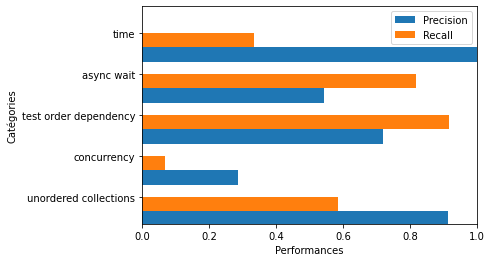

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000, random_state=123456)

eval_classifier (model , X_to_train , Y_to_train , test_set_to_array , test_labels)


### Decision Tree

                       precision    recall  f1-score   support

           async wait       0.53      0.54      0.53        71
          concurrency       0.17      0.20      0.18        30
test order dependency       0.64      0.68      0.66        73
                 time       0.35      0.20      0.26        30
unordered collections       0.50      0.53      0.51        36

             accuracy                           0.50       240
            macro avg       0.44      0.43      0.43       240
         weighted avg       0.49      0.50      0.49       240

Accuracy 0.5
MCC 0.34
AUC 0.67


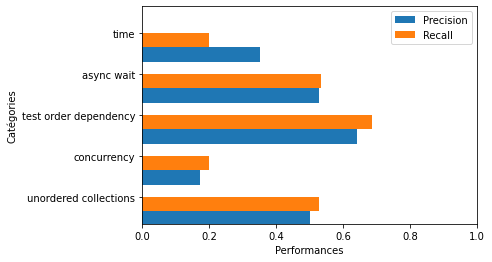

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
eval_classifier (model , X_to_train , Y_to_train , test_set_to_array , test_labels)

### K-Nearest Neighbors

                       precision    recall  f1-score   support

           async wait       0.44      0.70      0.54        71
          concurrency       0.17      0.10      0.12        30
test order dependency       0.72      0.74      0.73        73
                 time       1.00      0.30      0.46        30
unordered collections       0.42      0.28      0.33        36

             accuracy                           0.53       240
            macro avg       0.55      0.42      0.44       240
         weighted avg       0.56      0.53      0.51       240

Accuracy 0.52
MCC 0.37
AUC 0.68


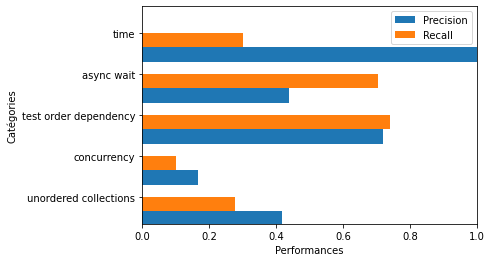

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
eval_classifier (model , X_to_train , Y_to_train , test_set_to_array , test_labels)

### Support Vector Machine

                       precision    recall  f1-score   support

           async wait       0.36      0.76      0.49        71
          concurrency       0.00      0.00      0.00        30
test order dependency       0.54      0.68      0.61        73
                 time       0.00      0.00      0.00        30
unordered collections       0.00      0.00      0.00        36

             accuracy                           0.43       240
            macro avg       0.18      0.29      0.22       240
         weighted avg       0.27      0.43      0.33       240

Accuracy 0.43
MCC 0.22
AUC 0.6


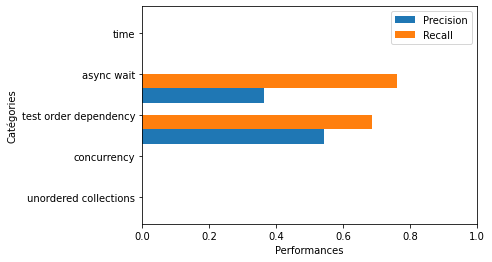

In [ ]:
from sklearn import svm
model = svm.SVC( C = 1. , kernel = 'rbf' , gamma  = 0.01)
eval_classifier (model , X_to_train , Y_to_train ,test_set_to_array , test_labels)